# Active polarization controller

In this notebook we want to guide you on how to use this package for the design and simulation of an active polarization controller.

To do so, we will use the `InP_EOPM` class created in the `Building a PhotonicdDevice` tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import imodulator
import shapely
import openbandparams as obp
from imodulator.ElectroOpticalModel import InGaAsPElectroOpticalModel
from imodulator.ChargeSimulator import ChargeSimulatorSolcore
from imodulator.ElectroOpticalSimulator import ElectroOpticalSimulator
from imodulator.OpticalSimulator import OpticalSimulatorFEMWELL

%matplotlib inline

def tand_fitted_bcb(x):
    """
    Fitted to results from https://link.springer.com/article/10.1007/s10762-009-9552-0
    
    x must be in GHz
    """
    out =  0.0093839 - 0.01790336 * np.exp(-0.04773444 * (x - -4.64170761))

    if isinstance(x, (list, np.ndarray)):
        x = np.asarray(x)
    
        out[np.where(out<0.001)] = 0.001
    else:
        if out < 0.001:
            out = 0.001
    return out

class InP_EOPM:
    def __init__(
            self,
            **kwargs
    ):
        
        self.e = 1.60e-19 # electron charge in C
        self.e0 = 8.85e-12 # vacuum permittivity in F/m
        
        self.w_sig_metal = 5 # Width of signal metal in um
        self.metal_sep = 10 # Separation between signal and ground metals in um
        self.h_metal = 4 # Height of metals in um
        self.w_gnd_metal = 10
        
        self.w_wg = 1
        self.h_n = 0.4
        self.h_wg1 = 0.5
        self.h_wg2 = 0.3
        self.h_p1 = 1
        self.h_p2 = 0.2

        self.h_box = 4

        self.w_window = 100
        self.h_bottom = 30
        self.h_top = 30

        for kwarg, value in kwargs.items():
            if hasattr(self, kwarg):
                setattr(self, kwarg, value)
    
    def _make_meshes(self):
        # optical mesh
        self.optical_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        # RF mesh
        self.rf_mesh_settings = {
            'substrate': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'sig_metal': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_left': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_right': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'bcb': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
        }

        # eo mesh
        self.eo_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.05, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.05, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.05, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        self.charge_mesh_settings = {
            'substrate': {'resolution': 0.5},
            'background': {'resolution': 0.5},
            'sig_metal': {'resolution': 0.01},
            'n_metal_left': {'resolution': 0.01},
            'n_metal_right': {'resolution': 0.01},
            'n': {'resolution': 0.003},
            'wg1': {'resolution': 0.002},
            'wg2': {'resolution': 0.002},
            'p1': {'resolution': 0.003},
            'p2': {'resolution': 0.003},
        }

    def _create_polygons(self):
        #We will now set the RF properties of the metals and the BCB
        freq = np.linspace(0.1,100, 100) #GHz. This will be the simulation frequency
            
        eps_rf_metal = 1 - 1j*6e7/(2*np.pi*freq*1e9 * self.e0)
        eps_rf_metal = np.asarray([freq, eps_rf_metal])
        
        bcb_eps_real = 2.65*np.ones(100)
        bcb_eps_imag = bcb_eps_real * tand_fitted_bcb(freq)

        bcb_eps = bcb_eps_real - 1j*bcb_eps_imag
        bcb_eps = np.asarray([freq, bcb_eps])
        
        #Now we create the PhotoPolygons
        self.substrate = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box - self.h_bottom,
                self.w_window/2,
                -self.h_box
            ),
            rf_eps = 11.7,
            name = 'substrate',
            optical_material=3**2,
            eo_mesh_settings=self.eo_mesh_settings['substrate'],
            rf_mesh_settings=self.rf_mesh_settings['substrate'],
            optical_mesh_settings=self.optical_mesh_settings['substrate'],
        )

        self.background = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box - self.h_bottom,
                self.w_window/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal + self.h_top
            ),
            rf_eps = 1,
            optical_material=1,
            eo_mesh_settings=self.eo_mesh_settings['background'],
            rf_mesh_settings=self.rf_mesh_settings['background'],
            optical_mesh_settings=self.optical_mesh_settings['background'],
            name = 'background'
        )

        self.box = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box,
                self.w_window/2,
                0
            ),
            rf_eps = 3.9 - 1j*3.9*0.001,
            optical_material=1.44**2,
            eo_mesh_settings=self.eo_mesh_settings['box'],
            rf_mesh_settings=self.rf_mesh_settings['box'],
            optical_mesh_settings=self.optical_mesh_settings['box'],
            name = 'box'
        )

        n_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.n = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                0,
                self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
                self.h_n
            ),
            rf_eps = n_obp_material.dielectric(T=300),
            optical_material=n_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['n'],
            rf_mesh_settings=self.rf_mesh_settings['n'],
            optical_mesh_settings=self.optical_mesh_settings['n'],
            charge_mesh_settings=self.charge_mesh_settings['n'],
            name = 'n',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': n_obp_material,
                'sol_Nd': 1e18
            }
        )

        wg1_obp_material = obp.GaInPAs(T=300, As = 0.53, a = obp.InP.a())
        self.wg1 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n,
                self.w_wg/2,
                self.h_n + self.h_wg1
            ),
            rf_eps = wg1_obp_material.dielectric(T=300),
            optical_material=wg1_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['wg1'],
            rf_mesh_settings=self.rf_mesh_settings['wg1'],
            optical_mesh_settings=self.optical_mesh_settings['wg1'],
            charge_mesh_settings=self.charge_mesh_settings['wg1'],
            name = 'wg1',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0.53,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg1_obp_material,
                'sol_Nd': 1e16
            }
        )

        wg2_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.wg2 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2
            ),
            rf_eps = wg2_obp_material.dielectric(T=300),
            optical_material=wg2_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['wg2'],
            rf_mesh_settings=self.rf_mesh_settings['wg2'],
            optical_mesh_settings=self.optical_mesh_settings['wg2'],
            charge_mesh_settings=self.charge_mesh_settings['wg2'],
            name = 'wg2',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg2_obp_material,
                'sol_Nd': 1e16
            }
        )

        p1_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.p1 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1
            ),
            rf_eps = p1_obp_material.dielectric(T=300),
            optical_material=p1_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['p1'],
            rf_mesh_settings=self.rf_mesh_settings['p1'],
            optical_mesh_settings=self.optical_mesh_settings['p1'],
            charge_mesh_settings=self.charge_mesh_settings['p1'],
            name = 'p1',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg2_obp_material,
                'sol_Na': 1e17
            }
        )

        p2_obp_material = obp.GaInAs(T=300, a = obp.InP.a())
        self.p2 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = p2_obp_material.dielectric(T=300),
            optical_material=p2_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['p2'],
            rf_mesh_settings=self.rf_mesh_settings['p2'],
            optical_mesh_settings=self.optical_mesh_settings['p2'],
            charge_mesh_settings=self.charge_mesh_settings['p2'],
            name = 'p2',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': p2_obp_material,
                'sol_Na': 1e19
            }
        )

        self.bcb_far_left = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                0,
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_far_left'
        )

        self.bcb_far_right = imodulator.InsulatorPolygon(
            shapely.box(
                self.metal_sep + self.w_gnd_metal + self.w_sig_metal/2,
                0,
                self.w_window/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_far_right'
        )

        self.bcb_left = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep,
                self.h_n,
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_left'
        )

        self.bcb_right = imodulator.InsulatorPolygon(
            shapely.box(
                self.w_wg/2,
                self.h_n,
                self.w_sig_metal/2 + self.metal_sep,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_right'
        )

        self.sig_metal = imodulator.MetalPolygon(
            shapely.box(
                -self.w_sig_metal/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2,
                self.w_sig_metal/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['sig_metal'],
            rf_mesh_settings=self.rf_mesh_settings['sig_metal'],
            optical_mesh_settings=self.optical_mesh_settings['sig_metal'],
            name = 'sig_metal',
            calculate_current=True,
            d_buffer_current=min(self.w_sig_metal/20, self.h_metal/20, 0.05)
        )

        self.n_metal_left = imodulator.MetalPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                self.h_n,
                -self.w_sig_metal/2 - self.metal_sep,
                self.h_n + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['n_metal_left'],
            rf_mesh_settings=self.rf_mesh_settings['n_metal_left'],
            optical_mesh_settings=self.optical_mesh_settings['n_metal_left'],
            name = 'n_metal_left',
            calculate_current=False
        )

        self.n_metal_right = imodulator.MetalPolygon(
            shapely.box(
                self.w_sig_metal/2 + self.metal_sep,
                self.h_n,
                self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
                self.h_n + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['n_metal_right'],
            rf_mesh_settings=self.rf_mesh_settings['n_metal_right'],
            optical_mesh_settings=self.optical_mesh_settings['n_metal_right'],
            name = 'n_metal_right',
            calculate_current=False
        )

    def _initialize_device(self):
        photo_polygons = [
            self.sig_metal,
            self.n_metal_left,
            self.n_metal_right,
            self.p2,
            self.p1,
            self.wg2,
            self.wg1,
            self.n,
            self.box,
            self.bcb_left,
            self.bcb_right,
            self.bcb_far_left,
            self.bcb_far_right,
            self.substrate,
            self.background
        ]
        
        #Just in case there are empty polygons
        idxs_to_remove = []
        for i, poly in enumerate(photo_polygons):
            if np.isclose(poly.polygon.bounds[1], poly.polygon.bounds[3]):
                idxs_to_remove.append(i)
        for i in idxs_to_remove[::-1]:
            del photo_polygons[i]
        self.device = imodulator.PhotonicDevice(
            photo_polygons
        )

Successfully imported lumapi


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\solcore\registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


Successfully imported nextnanopy
Successfully configured nextnano++ settings


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\nextnanopy\defaults.py:202: UserWarning: Unsupported products in config file: ['nextnano.NEGF++'] will be ignored. To not see this message, please remove unsupported products from the config file: C:\Users\20230622\.nextnanopy-configNote: nextnano.NEGF++ was renamed to nextnano.NEGF, nextnano.NEGF was renamed to nextnano.NEGF_classic. Please check the documentation for more details.
  warnings.warn(


## Phase matching condition

Our first task is to study the modes as a function of the waveguide width in the hopes of finding a phase matching condition. To get some better accuracy we will do 10 mesh refinement steps for each width value and we will use the most TE mode with highest confinement factor in the waveguide core. We will then save the data of only the TE and TM modes.
 

In [2]:
width_values = np.linspace(0.5, 2, 10)

N_modes = 5
N_iterations_refinement = 10

neff = np.zeros((len(width_values), 2))
loss = np.zeros((len(width_values), 2))

mesh_refinement_data = []

for i, w_wg in enumerate(width_values):
    print(f'Simulating width {w_wg} um')
    
    eopm = InP_EOPM(
        w_wg = w_wg
    )

    eopm._make_meshes()
    eopm._create_polygons()
    eopm._initialize_device()

    mode = OpticalSimulatorFEMWELL(
        device=eopm.device,
        simulation_window=shapely.box(-4,-1,4,4),
        include_metals=False
    )

    mode.make_mesh()

    neff_ref = []
    loss_ref = []
    nelements_ref = []
    for h in range(N_iterations_refinement):
        #Just a nice progress bar
        M = N_iterations_refinement
        if h == M - 1:
            j = 100
        else:
            j = round((h + 1) * 100 / M)
        bar = "#" * (j // 2) + "-" * (50 - j // 2)
        print(f"mesh refinement [{bar}] {j:3d}%", end="\r", flush=True)
        # time.sleep(0.05)

        modes = mode.compute_modes(
            wavelength=1.55,
            num_modes=5,
            order=1,
            metallic_boundaries=False,
            n_guess=3.5,
            return_modes=True
        )

        loss_tmp = []
        for opt_mode in mode.modes:
            loss_tmp.append(opt_mode.calculate_propagation_loss(1e4))

        # We will use the mode that is closest to a TE mode for the refinement
        te_fractions = np.array([opt_mode.te_fraction for opt_mode in mode.modes])
        conf_factors = []

        elements = mode.mesh.subdomains['wg1']
        for opt_mode in modes:
            conf_factors.append(opt_mode.calculate_confinement_factor(elements))
        conf_factors = np.array(conf_factors)

        idx_mode = np.argmax(conf_factors * te_fractions)

        nelements_ref.append(mode.mesh.nelements)
        neff_ref.append(mode.modes[idx_mode].n_eff.real)
        loss_ref.append(mode.modes[idx_mode].calculate_propagation_loss(1e4))

        mode.refine_mesh(mode_for_refinement=mode.modes[idx_mode])

    mesh_refinement_data.append({
        'width': w_wg,
        'neff': neff_ref,
        'loss': loss_ref,
        'nelements': nelements_ref
    })

    #Compute the modes
    modes = mode.compute_modes(
            wavelength=1.55,
            num_modes=N_modes,
            order=1,
            metallic_boundaries=False,
            n_guess=3.5,
            return_modes=True
        )
    
    #Find TE and TM modes and store neff and loss
    te_fractions = np.array([opt_mode.te_fraction for opt_mode in modes])
    conf_factors = []

    elements = mode.mesh.subdomains['wg1']
    for opt_mode in modes:
        conf_factors.append(opt_mode.calculate_confinement_factor(elements))
    conf_factors = np.array(conf_factors)

    TE_TM_modes = np.argsort(conf_factors)[-2:]

    if te_fractions[TE_TM_modes[0]] < te_fractions[TE_TM_modes[1]]:
        TE_mode_idx = TE_TM_modes[1]
        TM_mode_idx = TE_TM_modes[0]
    else:
        TE_mode_idx = TE_TM_modes[0]
        TM_mode_idx = TE_TM_modes[1]

    neff[i,0] = modes[TE_mode_idx].n_eff.real
    loss[i,0] = modes[TE_mode_idx].calculate_propagation_loss(1e4)

    neff[i,1] = modes[TM_mode_idx].n_eff.real
    loss[i,1] = modes[TM_mode_idx].calculate_propagation_loss(1e4)

Simulating width 0.5 um
Simulating width 0.6666666666666666 um#############################] 100%
Simulating width 0.8333333333333333 um#############################] 100%
Simulating width 1.0 um############################################] 100%
Simulating width 1.1666666666666665 um#############################] 100%
Simulating width 1.3333333333333333 um#############################] 100%
Simulating width 1.5 um############################################] 100%
Simulating width 1.6666666666666665 um#############################] 100%
Simulating width 1.8333333333333333 um#############################] 100%
Simulating width 2.0 um############################################] 100%


We can now check the effective index of the TE and TM modes

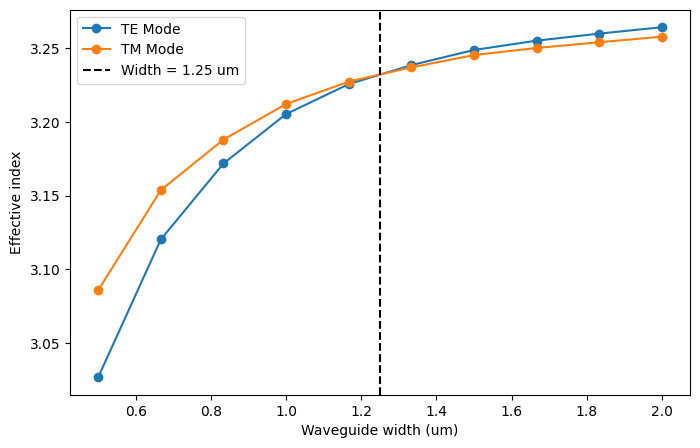

In [3]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

ax.plot(width_values, neff[:,0], label=f'TE Mode', marker='o')
ax.plot(width_values, neff[:,1], label=f'TM Mode', marker='o')

ax.set_xlabel('Waveguide width (um)')
ax.set_ylabel('Effective index')

x0 = 1.25
ax.axvline(x0, color='black', linestyle='--', label=f'Width = {x0:.2f} um')

ax.legend()

Now we calculate the modes again and inspect them

Effective index - mode 0: 3.3101###################################] 100%
loss - mode 0: 59032.28 dB/cm
#------------------------------------------#
Effective index - mode 1: 3.2629
loss - mode 1: 49218.90 dB/cm
#------------------------------------------#
Effective index - mode 2: 3.2325
loss - mode 2: 4.38 dB/cm
#------------------------------------------#
Effective index - mode 3: 3.2324
loss - mode 3: 9.33 dB/cm
#------------------------------------------#
Effective index - mode 4: 3.1550
loss - mode 4: 60798.24 dB/cm
#------------------------------------------#


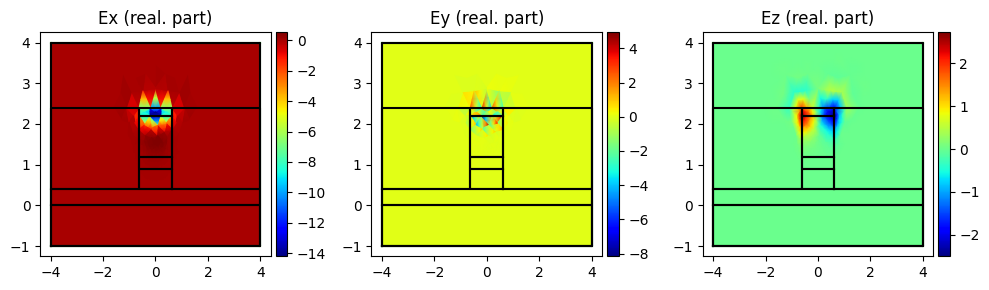

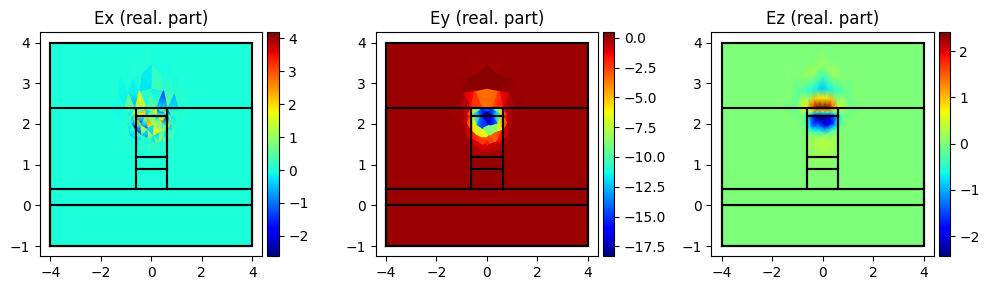

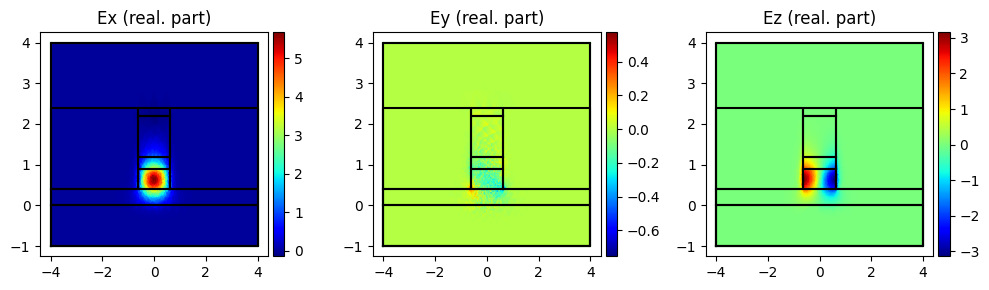

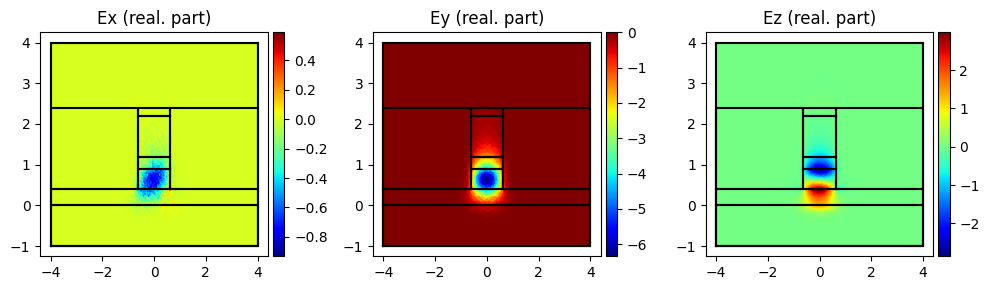

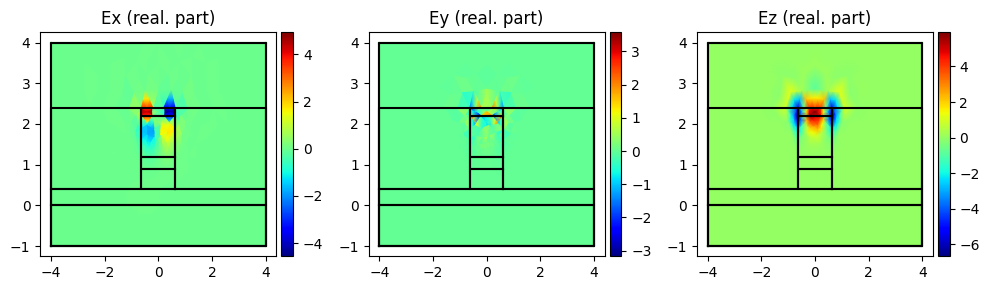

In [4]:
eopm = InP_EOPM(
    w_wg = 1.25
)

eopm._make_meshes()
eopm._create_polygons()
eopm._initialize_device()

mode = OpticalSimulatorFEMWELL(
    device=eopm.device,
    simulation_window=shapely.box(-4,-1,4,4),
    include_metals=False
)

mode.make_mesh()

neff_ref = []
loss_ref = []
nelements_ref = []
for h in range(N_iterations_refinement):
    #Just a nice progress bar
    M = N_iterations_refinement
    if h == M - 1:
        j = 100
    else:
        j = round((h + 1) * 100 / M)
    bar = "#" * (j // 2) + "-" * (50 - j // 2)
    print(f"mesh refinement [{bar}] {j:3d}%", end="\r", flush=True)
    # time.sleep(0.05)

    modes = mode.compute_modes(
        wavelength=1.55,
        num_modes=5,
        order=1,
        metallic_boundaries=False,
        n_guess=3.5,
        return_modes=True
    )

    # We will use the mode that is closest to a TE mode for the refinement
    te_fractions = np.array([opt_mode.te_fraction for opt_mode in mode.modes])
    conf_factors = []

    elements = mode.mesh.subdomains['wg1']
    for opt_mode in modes:
        conf_factors.append(opt_mode.calculate_confinement_factor(elements))
    conf_factors = np.array(conf_factors)

    idx_mode = np.argmax(conf_factors * te_fractions)

    nelements_ref.append(mode.mesh.nelements)
    neff_ref.append(mode.modes[idx_mode].n_eff.real)
    loss_ref.append(mode.modes[idx_mode].calculate_propagation_loss(1e4))

    mode.refine_mesh(mode_for_refinement=mode.modes[idx_mode])

modes = mode.compute_modes(
    wavelength=1.55,
    num_modes=5,
    order=1,
    metallic_boundaries=False,
    n_guess=3.5,
    return_modes=True
)

for i in range(len(modes)):
    print(f'Effective index - mode {i}: {modes[i].n_eff.real:.4f}')
    print(f'loss - mode {i}: {modes[i].calculate_propagation_loss(1e4):.2f} dB/cm')
    print('#------------------------------------------#')

for i in range(len(modes)):
    mode.plot_mode(
        mode=modes[i],
    )

In [5]:
mode.transfer_results_to_device(
    TE_TM_idx=[2,3]
)

c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


## Solving the PDD

Now that we have our modes, we can calculate the charge transport quantities:

Charge transport will take place with:
p2
p1
wg2
wg1
n


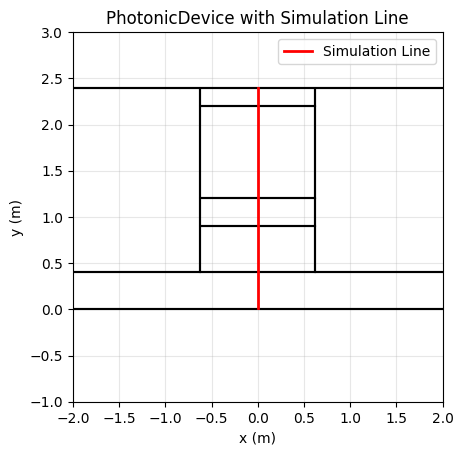

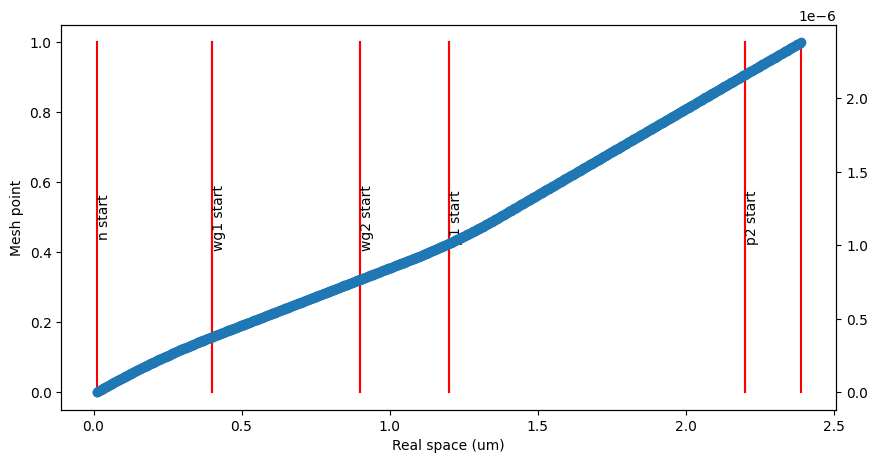

In [6]:
a=shapely.LineString([
    [0,0+0.01],
    [0,eopm.h_n+eopm.h_wg1+eopm.h_wg2+eopm.h_p1+eopm.h_p2 - 0.01]]) #simulation line

charge=ChargeSimulatorSolcore(
    device=eopm.device,
    simulation_line=a,
    bias_start_stop_step=[0,8,30]
)

fig, ax = charge.plot_with_simulation_line()

ax.set_xlim(-2,2)
ax.set_ylim(-1,3)

charge.plot_mesh()
plt.show()

Material "n" does not have k-data defined. Returning "zeros"
Material "wg1" does not have k-data defined. Returning "zeros"
Material "wg2" does not have k-data defined. Returning "zeros"
Material "p1" does not have k-data defined. Returning "zeros"
Material "p2" does not have k-data defined. Returning "zeros"
Solving IV of the junctions...


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\solcore\sesame_drift_diffusion\solve_pdd.py:193: UserWarning: All voltages are positive, but junction has been identified as n-p, so the  open-circuit voltage (Voc) of the junction will be negative.
  warnings.warn(


Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


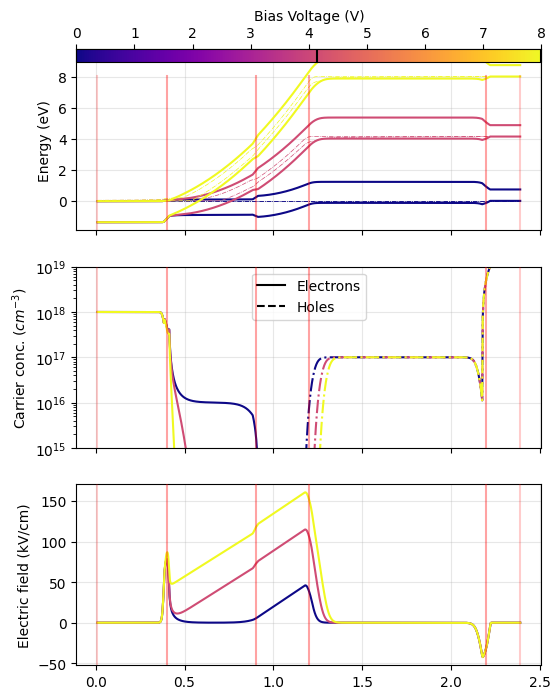

In [7]:
charge.solve_PDD(
    verbose = True*0,
    tol = 1e-6,
    max_iter = 1000,
    smooth_output=True,
)

charge.plot_results(
    V_idx = [0,
			 int(len(charge.V)/2),
			 len(charge.V)-1
			 ],
    cmap = 'plasma'
    )

In [8]:
charge.transfer_results_to_device(xmin=-2, xmax=2, dx = 0.01)

## Calculate the electro-optic response

Now that we have the optical modes and the PDD data we can calculate the coupling constants

Text(0, 0.5, 'y (um)')

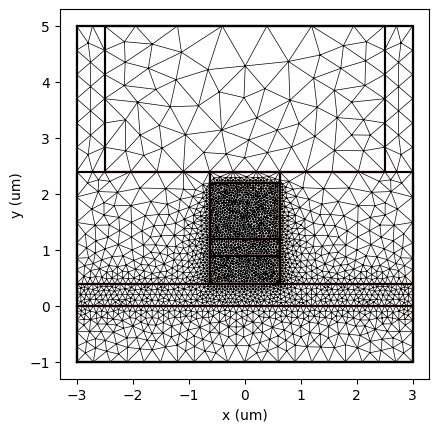

In [9]:
EO=ElectroOpticalSimulator(
	device=eopm.device,
	simulation_window=shapely.box(-3,-1,3,5)
	)

EO.make_mesh()

fig, ax = EO.plot_mesh()
EO.plot_polygons(ax=ax)

ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')

In [10]:
EO.get_epsilon_optical()

c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\pint\facets\numpy\numpy_func.py:322: RuntimeWarning: invalid value encountered in sqrt
  result_magnitude = func(*stripped_args, **stripped_kwargs)
c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\pint\facets\plain\quantity.py:1006: RuntimeWarning: divide by zero encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\pint\facets\plain\quantity.py:1006: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
C:\Users\20230622\OneDrive - TU Eindhoven\PhD\Python packages\photonmod\src\imodulator\ElectroOpticalSimulator.py:367: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  epsilon_optical_all[EO_model_name]['dperms'][:, :, vertices_idxs, voltage_idx, perm_idx] = p

The only effect in our system that can cause polarization conversion is the pockels effect, but only if we keep the $\Delta \epsilon$ non-diagonal. Therefore, we shall study it as a function of angle as well.

In [11]:
#Calculate the EO response for all voltages
angle_values = np.linspace(0, np.pi, 100)

kappa_te_te = np.zeros((len(angle_values), len(eopm.device.charge['V']), 5), dtype=complex)
kappa_te_tm = np.zeros((len(angle_values), len(eopm.device.charge['V']), 5), dtype=complex)
kappa_tm_te = np.zeros((len(angle_values), len(eopm.device.charge['V']), 5), dtype=complex)
kappa_tm_tm = np.zeros((len(angle_values), len(eopm.device.charge['V']), 5), dtype=complex)

for j in range(len(angle_values)):
    #Just a nice progress bar
    M = len(angle_values)
    if j == M - 1:
        prog = 100
    else:
        prog = round((j + 1) * 100 / M)
    bar = "#" * (prog // 2) + "-" * (50 - prog // 2)
    print(f"Calculating EO response [{bar}] {prog:3d}%", end="\r", flush=True)

    for i in range(len(eopm.device.charge['V'])):

        for mode_a, mode_b, storage_list in zip(
            ['TE', 'TE', 'TM', 'TM'],
            ['TE', 'TM', 'TE', 'TM'],
            [kappa_te_te, kappa_te_tm, kappa_tm_te, kappa_tm_tm]
        ):
            kappa = EO.calculate_EO_response(
                voltage_idx=i,
                rot_x=0,
                rot_y=angle_values[j],
                rot_z=0,
                base_epsilon_voltage_idx=0,
                optical_mode_a=mode_a,
                optical_mode_b=mode_b,
            )
            storage_list[j,i] = kappa['InGaAsPElectroOpticalModel']['results']

<>:35: DeprecationWarning: invalid escape sequence '\k'
<>:36: DeprecationWarning: invalid escape sequence '\k'
<>:35: DeprecationWarning: invalid escape sequence '\k'
<>:36: DeprecationWarning: invalid escape sequence '\k'
C:\Users\20230622\AppData\Local\Temp\ipykernel_29600\779305644.py:35: DeprecationWarning: invalid escape sequence '\k'
  ax.set_xlabel('Re($\kappa_{TE,TM}$)')
C:\Users\20230622\AppData\Local\Temp\ipykernel_29600\779305644.py:36: DeprecationWarning: invalid escape sequence '\k'
  ax.set_ylabel('Im($\kappa_{TE,TM}$)')


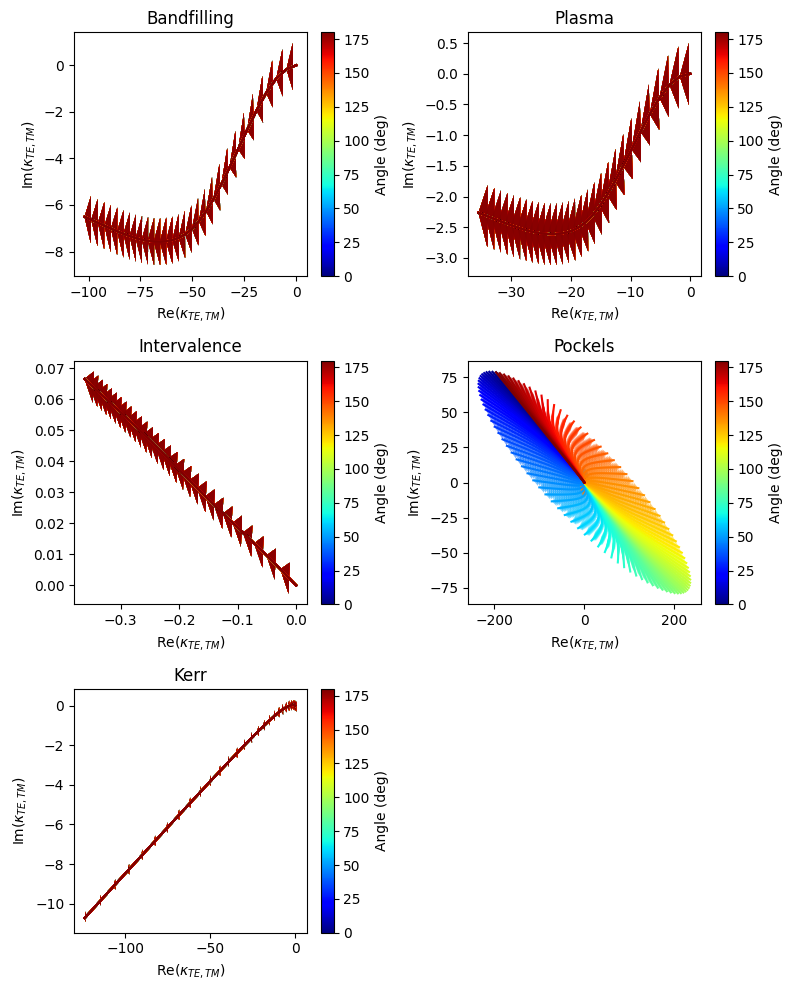

In [12]:
from matplotlib.colors import Normalize

import matplotlib.cm as cm
fig = plt.figure(figsize=(8,10))
gs = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2,0])

colors = cm.jet(np.linspace(0, 1, len(angle_values)))

arrow_width = [2,1,0.01,7,0.5]
for k, ax, title in zip(
    [0,1,2,3,4],
    [ax1, ax2, ax3, ax4, ax5],
    kappa['InGaAsPElectroOpticalModel']['labels']
):
    for i, angle in enumerate(angle_values):
        x = kappa_te_tm[i,:,k].real
        y = kappa_te_tm[i,:,k].imag

        ax.plot(x, y, label=f'Angle = {angle*180/np.pi:.1f}°', color = colors[i])

        for j in range(len(x) - 1):
            ax.arrow(
                x[j], y[j],
                x[j+1] - x[j],
                y[j+1] - y[j],
                shape='full', lw=0, length_includes_head=True, head_width=arrow_width[k], color=colors[i], alpha=0.5
            )

    ax.set_xlabel('Re($\kappa_{TE,TM}$)')
    ax.set_ylabel('Im($\kappa_{TE,TM}$)')
    ax.set_title(title)

fig.tight_layout()


# ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sm = cm.ScalarMappable(cmap=cm.jet, norm=Normalize(vmin=angle_values[0]*180/np.pi, vmax=angle_values[-1]*180/np.pi))
sm.set_array([])

for ax in [ax1, ax2, ax3, ax4, ax5]:
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Angle (deg)')

fig.tight_layout()

<>:35: DeprecationWarning: invalid escape sequence '\k'
<>:36: DeprecationWarning: invalid escape sequence '\k'
<>:35: DeprecationWarning: invalid escape sequence '\k'
<>:36: DeprecationWarning: invalid escape sequence '\k'
C:\Users\20230622\AppData\Local\Temp\ipykernel_29600\3195157124.py:35: DeprecationWarning: invalid escape sequence '\k'
  ax.set_xlabel('Re($\kappa_{TM,TE}$)')
C:\Users\20230622\AppData\Local\Temp\ipykernel_29600\3195157124.py:36: DeprecationWarning: invalid escape sequence '\k'
  ax.set_ylabel('Im($\kappa_{TM,TE}$)')


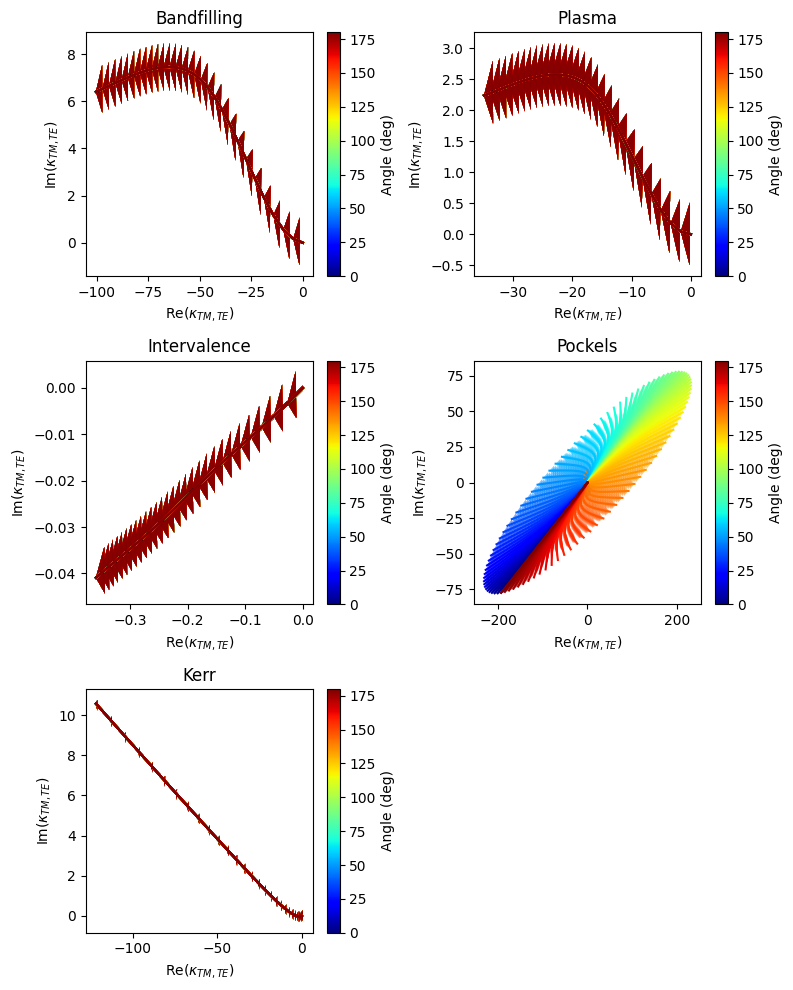

In [13]:
from matplotlib.colors import Normalize

import matplotlib.cm as cm
fig = plt.figure(figsize=(8,10))
gs = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2,0])

colors = cm.jet(np.linspace(0, 1, len(angle_values)))

arrow_width = [2,1,0.01,7,0.5]
for k, ax, title in zip(
    [0,1,2,3,4],
    [ax1, ax2, ax3, ax4, ax5],
    kappa['InGaAsPElectroOpticalModel']['labels']
):
    for i, angle in enumerate(angle_values):
        x = kappa_tm_te[i,:,k].real
        y = kappa_tm_te[i,:,k].imag

        ax.plot(x, y, label=f'Angle = {angle*180/np.pi:.1f}°', color = colors[i])

        for j in range(len(x) - 1):
            ax.arrow(
                x[j], y[j],
                x[j+1] - x[j],
                y[j+1] - y[j],
                shape='full', lw=0, length_includes_head=True, head_width=arrow_width[k], color=colors[i], alpha=0.5
            )

    ax.set_xlabel('Re($\kappa_{TM,TE}$)')
    ax.set_ylabel('Im($\kappa_{TM,TE}$)')
    ax.set_title(title)

fig.tight_layout()


# ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sm = cm.ScalarMappable(cmap=cm.jet, norm=Normalize(vmin=angle_values[0]*180/np.pi, vmax=angle_values[-1]*180/np.pi))
sm.set_array([])

for ax in [ax1, ax2, ax3, ax4, ax5]:
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Angle (deg)')

fig.tight_layout()

In the plot above, the color code is meant to represent the angle with respect to the y axis, and the direction of the arrows represents the increase in reverse bias voltage. We can clearly see that the most impactfull effect in the polarization conversion is by far the pockels effect. However, we see that the other effects also provide an effect. Because we are unsure if the theory holds for all effects, we will restrict ourselves to the pockels effect:

C:\Users\20230622\AppData\Local\Temp\ipykernel_29600\3798512384.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


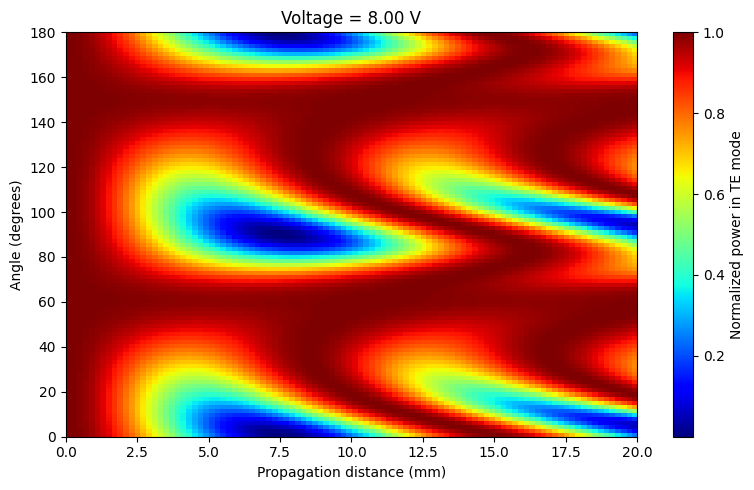

In [14]:
from scipy.integrate import solve_ivp

def f1(z,y, kaa=1, kbb=1, kba=0, kab=0, beta_TE=1, beta_TM=1):
    """
    This is the coupled mode equations for the TE and TM modes in the presence of coupling.
    """
    A=y[0]
    B=y[1]

    dAdz=1j*kaa*A+1j*kab*B*np.exp(1j*(beta_TM-beta_TE)*z)
    dBdz=1j*kbb*B+1j*kba*A*np.exp(-1j*(beta_TM-beta_TE)*z)

    return np.array([dAdz, dBdz])

z_space = np.linspace(0, 20e-3, 100)
A_values = np.zeros((len(angle_values), len(z_space)), dtype=complex)
B_values = np.zeros((len(angle_values), len(z_space)), dtype=complex)

for j in range(len(angle_values)):
    # print(f'Simulating propagation for angle {angle_values[j]*180/np.pi:.2f} degrees')
    idx = 3 #This will select only Pockels effect
    voltage_idx = -1

    k_aa = kappa_te_te[j,voltage_idx,idx]
    k_ab = kappa_te_tm[j,voltage_idx,idx]
    k_ba = kappa_tm_te[j,voltage_idx,idx]
    k_bb = kappa_tm_tm[j,voltage_idx,idx]

    beta_TE = mode.modes[2].k
    beta_TM = mode.modes[3].k


    result = solve_ivp(
        fun=lambda z, y: f1(z, y, kaa=k_aa, kbb=k_bb, kba=k_ba, kab=k_ab, beta_TE=beta_TE, beta_TM=beta_TM),
        t_span=(0, z_space[-1]),
        y0=np.array([1+0j, 0+0j]),
        t_eval=z_space,
        rtol = 1e-12,
        atol = 1e-12
    )

    A_values[j,:] = result.y[0]
    B_values[j,:] = result.y[1]

# plt.plot(z_space*1e3, np.abs(a)**2, label='TM')
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

# colors = cm.jet(np.linspace(0, 1, len(angle_values)))
# for j in range(len(angle_values)):
#     ax.plot(
#         z_space*1e3,
#         np.abs(A_values[j,:])**2,
#         label=f'Angle = {angle_values[j]*180/np.pi:.1f}°',
#         color = colors[j]
#     )

im = ax.imshow(
    np.abs(A_values)**2,
    extent=[z_space[0]*1e3, z_space[-1]*1e3, angle_values[0]*180/np.pi, angle_values[-1]*180/np.pi],
    aspect='auto',
    origin='lower',
    cmap='jet'
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Normalized power in TE mode')
ax.set_xlabel('Propagation distance (mm)')
ax.set_ylabel('Angle (degrees)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title('Voltage = {:.2f} V'.format(eopm.device.charge['V'][voltage_idx]))
fig.tight_layout()

We said we would restrict to pockels, but we can include all the effects and see what happens.

In [17]:
from scipy.integrate import solve_ivp

def f1(z,y, kaa=1, kbb=1, kba=0, kab=0, beta_TE=1, beta_TM=1):
    """
    This is the coupled mode equations for the TE and TM modes in the presence of coupling.
    """
    A=y[0]
    B=y[1]

    dAdz=1j*kaa*A+1j*kab*B*np.exp(1j*(beta_TM-beta_TE)*z)
    dBdz=1j*kbb*B+1j*kba*A*np.exp(-1j*(beta_TM-beta_TE)*z)

    return np.array([dAdz, dBdz])

z_space = np.linspace(0, 20e-3, 100)
A_values = np.zeros((len(angle_values), len(z_space)), dtype=complex)
B_values = np.zeros((len(angle_values), len(z_space)), dtype=complex)

for j in range(len(angle_values)):
    print(f'Simulating propagation for angle {angle_values[j]*180/np.pi:.2f} degrees')
    voltage_idx = -1

    k_aa = np.sum(kappa_te_te[j,voltage_idx], axis = -1)
    k_ab = np.sum(kappa_te_tm[j,voltage_idx], axis = -1)
    k_ba = np.sum(kappa_tm_te[j,voltage_idx], axis = -1)
    k_bb = np.sum(kappa_tm_tm[j,voltage_idx], axis = -1)

    beta_TE = mode.modes[2].k
    beta_TM = mode.modes[3].k


    result = solve_ivp(
        fun=lambda z, y: f1(z, y, kaa=k_aa, kbb=k_bb, kba=k_ba, kab=k_ab, beta_TE=beta_TE, beta_TM=beta_TM),
        t_span=(0, z_space[-1]),
        y0=np.array([1+0j, 0+0j]),
        t_eval=z_space,
        rtol = 1e-12,
        atol = 1e-12
    )

    A_values[j,:] = result.y[0]
    B_values[j,:] = result.y[1]

Simulating propagation for angle 0.00 degrees
Simulating propagation for angle 1.82 degrees
Simulating propagation for angle 3.64 degrees
Simulating propagation for angle 5.45 degrees
Simulating propagation for angle 7.27 degrees
Simulating propagation for angle 9.09 degrees
Simulating propagation for angle 10.91 degrees
Simulating propagation for angle 12.73 degrees
Simulating propagation for angle 14.55 degrees
Simulating propagation for angle 16.36 degrees
Simulating propagation for angle 18.18 degrees
Simulating propagation for angle 20.00 degrees
Simulating propagation for angle 21.82 degrees
Simulating propagation for angle 23.64 degrees
Simulating propagation for angle 25.45 degrees
Simulating propagation for angle 27.27 degrees
Simulating propagation for angle 29.09 degrees
Simulating propagation for angle 30.91 degrees
Simulating propagation for angle 32.73 degrees
Simulating propagation for angle 34.55 degrees
Simulating propagation for angle 36.36 degrees
Simulating propagat

C:\Users\20230622\AppData\Local\Temp\ipykernel_29600\649306782.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


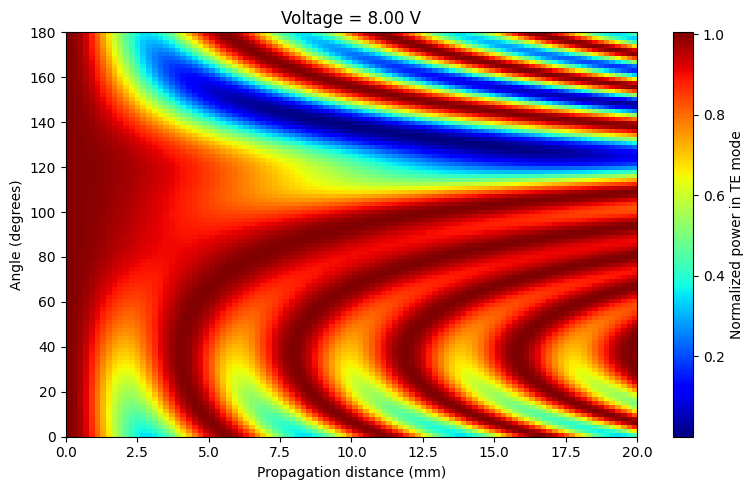

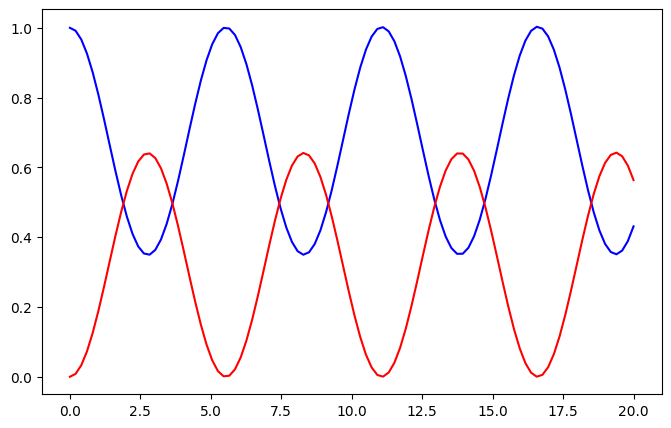

In [18]:
# plt.plot(z_space*1e3, np.abs(a)**2, label='TM')
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)


im = ax.imshow(
    np.abs(A_values)**2,
    extent=[z_space[0]*1e3, z_space[-1]*1e3, angle_values[0]*180/np.pi, angle_values[-1]*180/np.pi],
    aspect='auto',
    origin='lower',
    cmap='jet'
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Normalized power in TE mode')
ax.set_xlabel('Propagation distance (mm)')
ax.set_ylabel('Angle (degrees)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title('Voltage = {:.2f} V'.format(eopm.device.charge['V'][voltage_idx]))

fig.tight_layout()

#Plot only the 0 angle case
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

ax.plot(
    z_space*1e3,
    np.abs(A_values[0,:])**2,
    label=f'Angle = {angle_values[0]*180/np.pi:.1f}°',
    color = 'blue'
)

ax.plot(
    z_space*1e3,
    np.abs(B_values[0,:])**2,
    label=f'Angle = {angle_values[0]*180/np.pi:.1f}°',
    color = 'red'
)

Is this a physical result? We don't really know. Can you help?

Nonetheless, we can say something about the increase in performance when we consider the other effects. The reason for this increase in performance stems from the Kerr effect and the Z components of the optical fields which will allow the $k_{TE,TM}$ to have a contribution of the form $E_{z,TE}^* E_{z,TM} \Delta \epsilon _{zz}$, and since $\Delta \epsilon_{zz}$ is modulated efficiently by kerr effect, we have a better modulation.